In [1]:
import os
import sys

module_path = os.path.join(os.getcwd(), '..', 'module')
sys.path.append(module_path)

from Data_preparation import data_for_clust
from Data_preparation import quantity_executors
from Data_preparation import quantity_all
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

In [3]:
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering

In [4]:
# not_changed_df = pd.read_excel('../../data/Здания_Финальная_версия_ред.xlsx', 'Финальная ред')

not_changed_df = pd.read_excel('../../data/Финал_клин.xlsx', 'Финальная таблица')

In [5]:
not_changed_df['ИНН исполнителя'] = not_changed_df['ИНН исполнителя'].apply(
        lambda x: f"{int(x):.0f}" if pd.notna(x) else ''
    )

In [6]:
not_changed_df.head()

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток)
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",Исполнение завершено,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,Исполнение завершено,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,нет,Производство электромонтажных работ,NaN,NaN,NaN


In [7]:
print(quantity_all(not_changed_df))

Общее количество контрактов: 1000
Общая сумма контрактов: 2956463209.59
Общее количество исполнителей: 287
None


In [8]:
# first_df = data_for_clust('../../data/Здания_Финальная_версия_ред.xlsx', 'Финальная ред')

first_df = data_for_clust('../../data/Финал_клин.xlsx', 'Финальная таблица')

first_df = first_df.drop(0).reset_index(drop=True)


clust_data = first_df[['ИНН исполнителя', 'Средняя цена контракта', 'Количество контрактов']]


clust_data = clust_data.copy()

clust_data['Средняя цена контракта log'] = np.log1p(clust_data['Средняя цена контракта'])
clust_data['Количество контрактов log'] = np.log1p(clust_data['Количество контрактов'])

clust_data_new = clust_data.drop(['Средняя цена контракта', 'ИНН исполнителя', 'Количество контрактов'], axis=1)

In [9]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001232969,6411767.74,8.014710e+05,2078639.03,4979487.33,6.224359e+05,8,3903000.0,3797000.0,106000.0,2,0,0
1,1001334880,2904975.34,2.904975e+06,2904975.34,0.00,NaN,1,NaN,NaN,NaN,1,0,0
2,110110067712,6161831.51,3.080916e+06,4055831.51,6161831.51,3.080916e+06,2,NaN,NaN,NaN,0,0,0
3,1101159127,132459.55,1.324595e+05,132459.55,132459.55,1.324595e+05,1,15657000.0,390000.0,15267000.0,0,0,0
4,1435361389,790682.78,3.953414e+05,478406.28,223452.37,1.117262e+05,2,NaN,NaN,NaN,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,8610006030,22501451.72,1.323615e+06,3516000.00,21802540.10,1.282502e+06,17,22056000.0,14090000.0,7966000.0,1,1,0
282,910802239549,394264.61,1.971323e+05,298500.00,394264.61,1.971323e+05,2,NaN,NaN,NaN,0,0,0
283,9701160986,2022904.75,2.022905e+06,2022904.75,2022904.75,2.022905e+06,1,NaN,NaN,NaN,0,0,0
284,9717091512,5473516.12,5.473516e+06,5473516.12,5473516.12,5.473516e+06,1,10927000.0,10633000.0,294000.0,0,1,0


In [10]:
column_names = clust_data_new.columns
index_names = clust_data_new.index

scaler = MinMaxScaler()
clust_data_scaled = scaler.fit_transform(clust_data_new)

clust_data_scaled = pd.DataFrame(clust_data_scaled, 
                                columns=column_names,
                                index=index_names)


print(clust_data_scaled.head())

   Средняя цена контракта log  Количество контрактов log
0                    0.510968                   0.476426
1                    0.653038                   0.000000
2                    0.659526                   0.128434
3                    0.312363                   0.000000
4                    0.433001                   0.128434


In [11]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.510968,0.476426
1,0.653038,0.000000
2,0.659526,0.128434
3,0.312363,0.000000
4,0.433001,0.128434


In [12]:
clust_data_scaled.describe()

,Средняя цена контракта log,Количество контрактов log
count,286.000000,286.000000
mean,0.527362,0.163665
std,0.182701,0.205834
min,0.000000,0.000000
25%,0.420341,0.000000
50%,0.545730,0.128434
75%,0.636330,0.290241
max,1.000000,1.000000


In [13]:
clust_data_scaled

,Средняя цена контракта log,Количество контрактов log
0,0.510968,0.476426
1,0.653038,0.000000
2,0.659526,0.128434
3,0.312363,0.000000
4,0.433001,0.128434
...,...,...
281,0.566315,0.695985
282,0.356228,0.128434
283,0.613112,0.000000
284,0.722929,0.000000


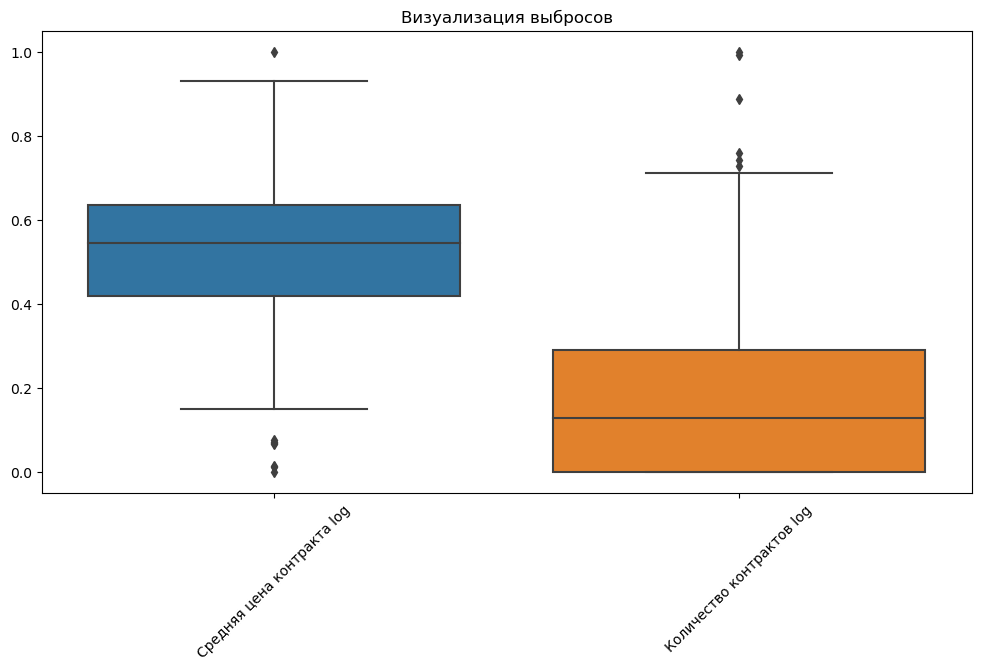

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=clust_data_scaled)
plt.xticks(rotation=45)
plt.title('Визуализация выбросов')
plt.show()

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

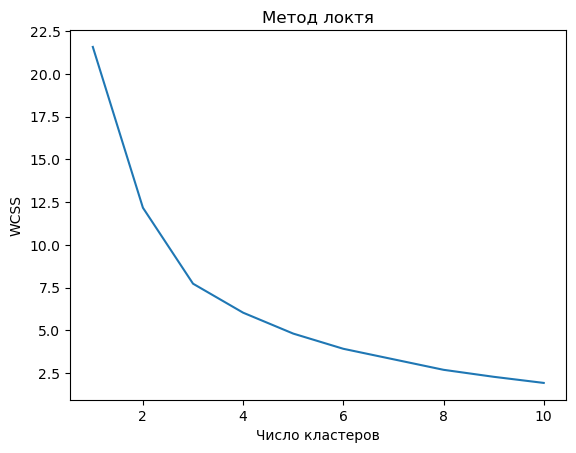

In [15]:
X = clust_data_scaled
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.show()

In [16]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [17]:
clust_data_scaled.columns.tolist()

['Средняя цена контракта log', 'Количество контрактов log']

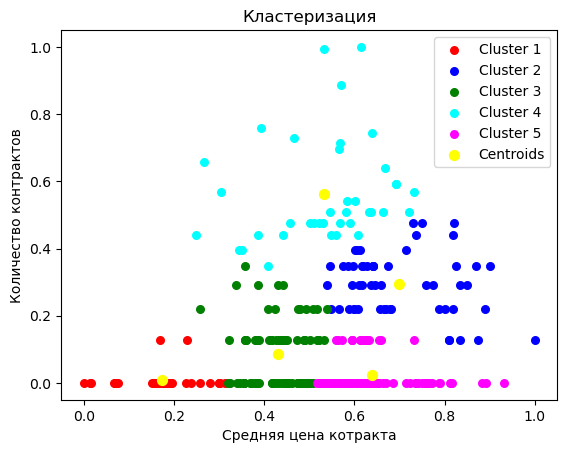

Центроиды кластеров:
   Средняя цена контракта log  Количество контрактов log  Кластер
0                    0.172577                   0.008857        0
1                    0.699009                   0.294350        1
2                    0.430308                   0.087357        2
3                    0.532591                   0.562945        3
4                    0.638147                   0.023784        4


In [18]:
X_array = X.values

plt.scatter(X_array[y_kmeans == 0, 0], X_array[y_kmeans == 0, 1], s=30, c='red', label='Cluster 1')
plt.scatter(X_array[y_kmeans == 1, 0], X_array[y_kmeans == 1, 1], s=30, c='blue', label='Cluster 2')
plt.scatter(X_array[y_kmeans == 2, 0], X_array[y_kmeans == 2, 1], s=30, c='green', label='Cluster 3')
plt.scatter(X_array[y_kmeans == 3, 0], X_array[y_kmeans == 3, 1], s=30, c='cyan', label='Cluster 4')
plt.scatter(X_array[y_kmeans == 4, 0], X_array[y_kmeans == 4, 1], s=30, c='magenta', label='Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='yellow', label='Centroids')
plt.title('Кластеризация')
plt.xlabel('Средняя цена котракта')
plt.ylabel('Количество контрактов')
plt.legend()
plt.show()

centroids = kmeans.cluster_centers_

centroids_df = pd.DataFrame(centroids, columns=clust_data_scaled.columns.tolist())
centroids_df['Кластер'] = range(len(centroids))

print("Центроиды кластеров:")
print(centroids_df)

In [19]:
clustered_data = X.copy()
clustered_data['Cluster'] = y_kmeans
clustered_data.head()

,Средняя цена контракта log,Количество контрактов log,Cluster
0,0.510968,0.476426,3
1,0.653038,0.000000,4
2,0.659526,0.128434,4
3,0.312363,0.000000,0
4,0.433001,0.128434,2


In [20]:
clustered_data = pd.concat([clust_data['ИНН исполнителя'].reset_index(drop=True), clustered_data.reset_index(drop=True)], axis=1)

In [21]:
clustered_data.head()

,ИНН исполнителя,Средняя цена контракта log,Количество контрактов log,Cluster
0,1001232969,0.510968,0.476426,3
1,1001334880,0.653038,0.000000,4
2,110110067712,0.659526,0.128434,4
3,1101159127,0.312363,0.000000,0
4,1435361389,0.433001,0.128434,2


In [22]:
data_with_clust = clust_data.copy()
data_with_clust['Cluster'] = y_kmeans
data_with_clust = data_with_clust.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1).round(2)
data_with_clust.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов,Cluster
0,1001232969,801470.97,8,3
1,1001334880,2904975.34,1,4
2,110110067712,3080915.76,2,4
3,1101159127,132459.55,1,0
4,1435361389,395341.39,2,2


In [23]:
result = data_with_clust.groupby('Cluster').agg({
    'Средняя цена контракта': 'mean',
    'Количество контрактов': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'count'}).round(2)
result.head()

,Средняя цена контракта,Количество контрактов,count
Cluster,,,
0,49376.61,1.07,29
1,7751309.33,4.28,54
2,441975.68,1.76,84
3,1582418.32,12.68,38
4,4056000.56,1.19,81


In [24]:
dbscan = DBSCAN(eps=0.09, min_samples=2)
clusters = dbscan.fit_predict(clust_data_scaled)

In [25]:
clusters

array([ 0,  1,  2,  1,  2,  1,  1,  0,  0, -1,  1,  0,  0,  2, -1,  0,  1,
        1,  1,  1,  2,  1,  1,  0,  1,  1,  1,  1,  1,  1,  2,  1,  2,  1,
        1,  2,  2,  2,  1,  1,  0,  0,  1,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  0,  2,  1,  3,  0,  1,  2,  1,  1,  0,  2,  1,  0,  1,  0,
        1,  2,  1,  1, -1,  2,  1,  1,  1,  2,  0,  2,  1,  1,  0,  1,  1,
        1,  1,  0,  1,  1,  1,  1,  2,  1,  0,  1,  0,  2,  1,  1,  3,  2,
        1,  1,  1,  1,  2,  1,  2,  1,  0,  1,  0,  1,  1,  1,  0,  0,  1,
        1,  1,  0,  1,  1,  0,  1,  1,  0,  0,  0,  4,  0,  1,  2,  1,  0,
        2,  0,  0,  0,  0,  0,  0,  5,  2,  1,  0,  1,  1,  0,  0,  1,  2,
        1,  1,  1,  2,  0,  2,  2,  1,  0,  6,  0,  1,  1,  1,  2,  1,  1,
        0,  1,  6, -1,  3,  3,  1,  0,  1,  0,  1,  2,  2,  0,  1,  4,  0,
        0,  3,  1,  2,  2,  1,  3,  0,  1,  1,  1,  0,  0,  0,  0,  1, -1,
        0,  1,  1,  0,  1,  2,  1,  0,  1,  1,  2,  7,  0,  0,  2,  1,  0,
        7,  1,  2,  0,  1

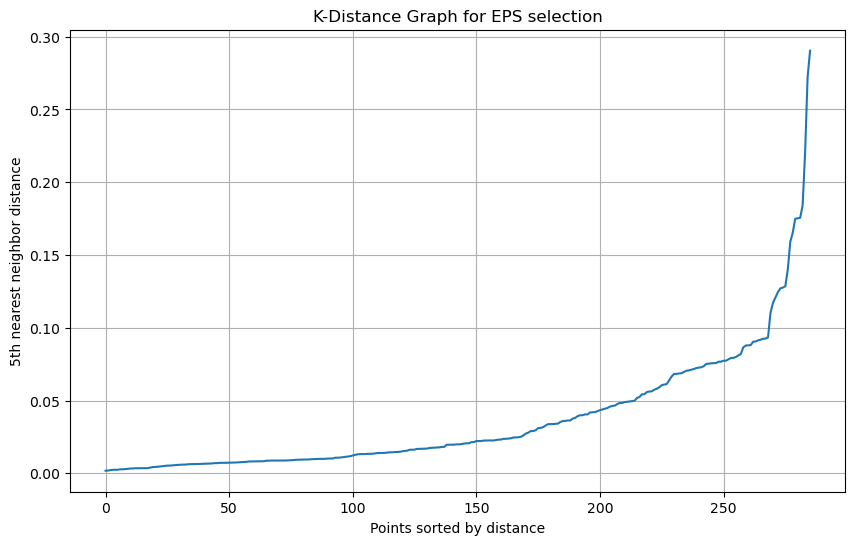

In [26]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(clust_data_scaled)
distances, indices = neighbors_fit.kneighbors(clust_data_scaled)

distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('K-Distance Graph for EPS selection')
plt.grid(True)

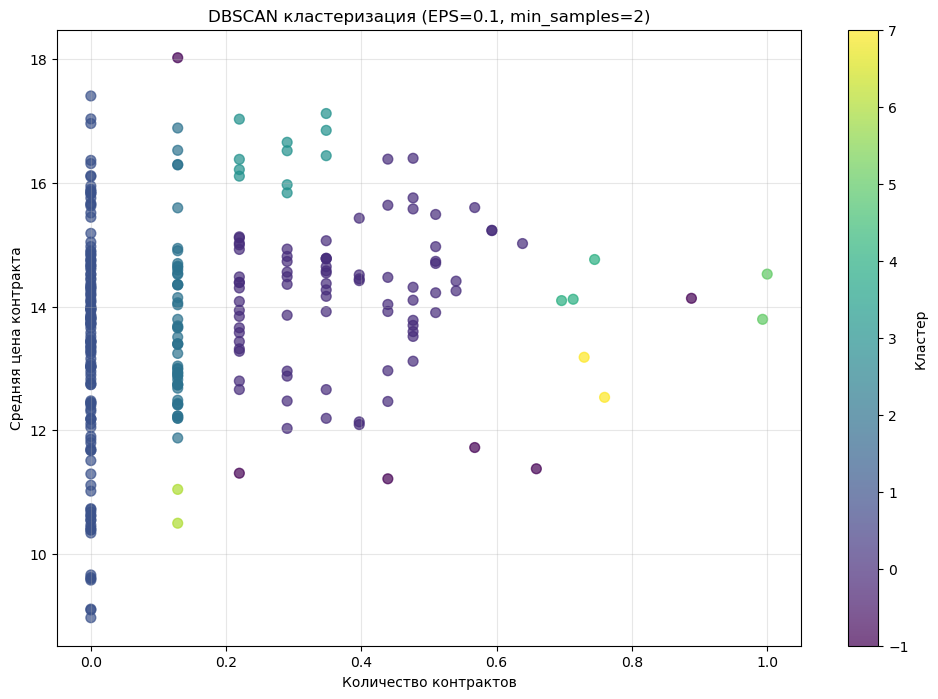

In [27]:

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clust_data_scaled['Количество контрактов log'], clust_data['Средняя цена контракта log'], 
                     c=clusters, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('Количество контрактов')
plt.ylabel('Средняя цена контракта')
plt.title('DBSCAN кластеризация (EPS=0.1, min_samples=2)')
plt.grid(True, alpha=0.3)

In [28]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.510968,0.476426
1,0.653038,0.000000
2,0.659526,0.128434
3,0.312363,0.000000
4,0.433001,0.128434


In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

hierarchical = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)

data = hierarchical.fit_predict(clust_data_scaled)

C:\Users\Alexander\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [30]:
data

array([1, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 2, 1, 0, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       2, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 2, 0, 0,
       0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0,
       1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 1, 0, 2, 0, 1, 0, 0, 2, 0],
      dtype=int64)

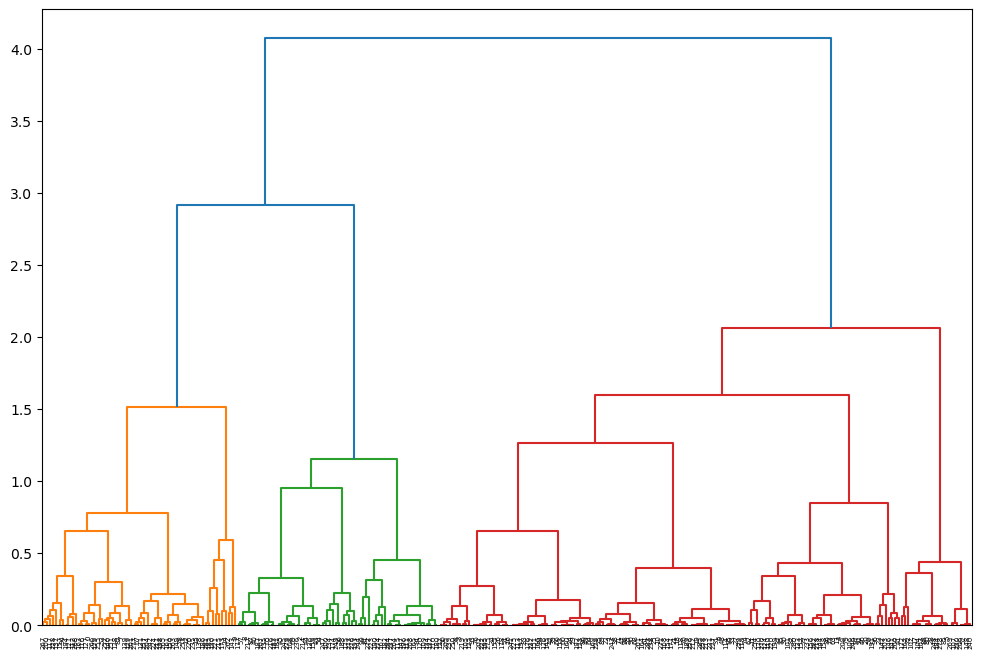

In [31]:
linked = linkage(clust_data_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='level',
           )
plt.show()

In [32]:
clust_data_scaled.head()

,Средняя цена контракта log,Количество контрактов log
0,0.510968,0.476426
1,0.653038,0.000000
2,0.659526,0.128434
3,0.312363,0.000000
4,0.433001,0.128434


In [33]:
clust_data_scaled.to_excel('Здания для кластеризации.xlsx', index=False)

In [34]:
clust_data_ex = clust_data.copy()
clust_data_ex = clust_data_ex.drop(['Средняя цена контракта log', 'Количество контрактов log'], axis = 1)
clust_data_ex.head()

,ИНН исполнителя,Средняя цена контракта,Количество контрактов
0,1001232969,8.014710e+05,8
1,1001334880,2.904975e+06,1
2,110110067712,3.080916e+06,2
3,1101159127,1.324595e+05,1
4,1435361389,3.953414e+05,2


In [35]:
clust_data_ex.to_excel('Здания для кластеризации 2.xlsx', index=False)

In [36]:
first_df[["ИНН исполнителя", "Средняя цена контракта", "Количество контрактов", "Прибыль(убыток)"]].to_excel('Здания для кластеризации 3.xlsx', index=False)

In [37]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001232969,6411767.74,8.014710e+05,2078639.03,4979487.33,6.224359e+05,8,3903000.0,3797000.0,106000.0,2,0,0
1,1001334880,2904975.34,2.904975e+06,2904975.34,0.00,NaN,1,NaN,NaN,NaN,1,0,0
2,110110067712,6161831.51,3.080916e+06,4055831.51,6161831.51,3.080916e+06,2,NaN,NaN,NaN,0,0,0
3,1101159127,132459.55,1.324595e+05,132459.55,132459.55,1.324595e+05,1,15657000.0,390000.0,15267000.0,0,0,0
4,1435361389,790682.78,3.953414e+05,478406.28,223452.37,1.117262e+05,2,NaN,NaN,NaN,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,8610006030,22501451.72,1.323615e+06,3516000.00,21802540.10,1.282502e+06,17,22056000.0,14090000.0,7966000.0,1,1,0
282,910802239549,394264.61,1.971323e+05,298500.00,394264.61,1.971323e+05,2,NaN,NaN,NaN,0,0,0
283,9701160986,2022904.75,2.022905e+06,2022904.75,2022904.75,2.022905e+06,1,NaN,NaN,NaN,0,0,0
284,9717091512,5473516.12,5.473516e+06,5473516.12,5473516.12,5.473516e+06,1,10927000.0,10633000.0,294000.0,0,1,0


In [38]:
similarity_df = first_df.drop(["Сумма контрактов", "Сумма оплат"], axis = 1)

In [39]:
# similarity_df = similarity_df.drop(0).reset_index(drop=True)

In [40]:
similarity_df.describe()

,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
count,2.860000e+02,2.860000e+02,2.770000e+02,286.000000,1.310000e+02,1.310000e+02,1.310000e+02,286.000000,286.000000,286.000000
mean,2.957331e+06,4.746140e+06,2.744077e+06,3.454545,6.770078e+07,6.053469e+07,7.166088e+06,0.755245,0.388112,0.132867
std,6.148321e+06,1.062490e+07,5.741093e+06,5.180567,1.158108e+08,1.107712e+08,1.177293e+07,1.610129,1.222479,0.340026
min,7.806000e+03,7.806000e+03,3.931440e+03,1.000000,0.000000e+00,0.000000e+00,-4.759000e+06,0.000000,0.000000,0.000000
25%,3.525095e+05,4.524021e+05,2.612160e+05,1.000000,1.261300e+07,1.086050e+07,4.375000e+05,0.000000,0.000000,0.000000
50%,1.098354e+06,1.473691e+06,9.855432e+05,2.000000,2.532900e+07,2.235300e+07,3.131000e+06,0.000000,0.000000,0.000000
75%,2.496720e+06,3.445658e+06,2.410802e+06,4.000000,8.412600e+07,7.214000e+07,8.395500e+06,1.000000,0.000000,0.000000
max,6.744398e+07,9.235670e+07,6.127358e+07,46.000000,1.066776e+09,1.058850e+09,8.906200e+07,18.000000,16.000000,1.000000


In [41]:
similarity_df.isna().sum().sum()

474

In [42]:
similarity = similarity_df.copy()

similarity['Рентабельность продаж'] = (( \
    similarity['Прибыль(убыток)'] / similarity['Доходы']) \
    .where(similarity['ИНН исполнителя'].astype(str).str.len() == 10)) \
    .replace([np.inf, -np.inf, np.nan], 0)

similarity['Доля прекращенных контрактов'] = (similarity['Количество прекращенных контрактов'] / similarity['Количество контрактов']) \
    .replace([np.inf, -np.inf, np.nan], 0)
    
similarity['Доля штрафных контрактов'] = (similarity['Неустойки (штрафы и пени)'] / similarity['Количество контрактов']) \
    .replace([np.inf, -np.inf, np.nan], 0)
    
similarity['Доля контракта от доходов'] = (( \
    similarity['Средняя цена контракта'] / similarity['Доходы']) \
    .where(similarity['ИНН исполнителя'].astype(str).str.len() == 10)) \
    .replace([np.inf, -np.inf, np.nan], 0)

similarity['Доля оплаты от цены контракта'] = (
    similarity['Средняя сумма оплат'] / similarity['Средняя цена контракта']
    )

fin_cols = ["Прибыль(убыток)", "Доля контракта от доходов", "Рентабельность продаж"]
similarity["Прибыль(убыток)"] = np.log1p(similarity["Прибыль(убыток)"])

scaler = MinMaxScaler()
df_fin_scaled = pd.DataFrame(scaler.fit_transform(similarity[fin_cols]), columns = fin_cols)

similarity["Финансовая устойчивость"] = df_fin_scaled.mean(axis = 1)
# similarity['Флаг цены'] = (
#     (similarity['Максимальная цена контракта'] > 250_000_000 * 0.2)
#     .astype(int)
# )

# similarity['Флаг контрактов'] = (
#     (similarity['Количество контрактов'] > 1)
#     .astype(int)
# )

# similarity['Флаг рентабельности'] = ((
#     similarity['Прибыль(убыток)'] / similarity['Доходы']
#     ).where(similarity['ИНН исполнителя'].astype(str).str.len() == 10) > 0.15).astype(int)
    

# similarity['Флаг прекращенных контрактов'] = (
#     (similarity['Количество прекращенных контрактов'] == 0)
#     .astype(int)
# )

# similarity['Флаг штрафов'] = (
#     (similarity['Неустойки (штрафы и пени)'] == 0)
#     .astype(int)
# )

# similarity['Флаг реестра'] = (
#     (similarity['Включение в реестр недобросовестных поставщиков'] == 0)
#     .astype(int)
# )

C:\Users\Alexander\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [43]:
df_fin_scaled.describe()

,Прибыль(убыток),Доля контракта от доходов,Рентабельность продаж
count,117.000000,286.000000,286.000000
mean,0.802998,0.015157,0.980153
std,0.140709,0.091746,0.058382
min,0.000000,0.000000,0.000000
25%,0.766893,0.000000,0.982867
50%,0.830575,0.000000,0.982867
75%,0.877666,0.001687,0.983953
max,1.000000,1.000000,1.000000


In [44]:
similarity.describe()

,Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость
count,2.860000e+02,2.860000e+02,2.770000e+02,286.000000,1.310000e+02,1.310000e+02,117.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,277.000000,286.000000
mean,2.957331e+06,4.746140e+06,2.744077e+06,3.454545,6.770078e+07,6.053469e+07,14.698753,0.755245,0.388112,0.132867,-0.156995,0.236849,0.114961,0.348948,0.918432,0.538918
std,6.148321e+06,1.062490e+07,5.741093e+06,5.180567,1.158108e+08,1.107712e+08,2.575664,1.610129,1.222479,0.340026,3.377151,0.363280,0.259194,2.112260,0.191958,0.067575
min,7.806000e+03,7.806000e+03,3.931440e+03,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-56.854839,0.000000,0.000000,0.000000,0.015682,0.327622
25%,3.525095e+05,4.524021e+05,2.612160e+05,1.000000,1.261300e+07,1.086050e+07,14.037855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955804,0.491434
50%,1.098354e+06,1.473691e+06,9.855432e+05,2.000000,2.532900e+07,2.235300e+07,15.203554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.491434
75%,2.496720e+06,3.445658e+06,2.410802e+06,4.000000,8.412600e+07,7.214000e+07,16.065539,1.000000,0.000000,0.000000,0.062836,0.428571,0.000000,0.038839,1.000000,0.601908
max,6.744398e+07,9.235670e+07,6.127358e+07,46.000000,1.066776e+09,1.058850e+09,18.304843,18.000000,16.000000,1.000000,0.991066,1.000000,1.000000,23.022845,1.253872,0.989755


In [45]:
similarity = similarity.drop([
                             "Доходы", "Расходы", "Прибыль(убыток)",
                             "Включение в реестр недобросовестных поставщиков"], axis = 1)

In [46]:
first_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001232969,6411767.74,8.014710e+05,2078639.03,4979487.33,6.224359e+05,8,3903000.0,3797000.0,106000.0,2,0,0
1,1001334880,2904975.34,2.904975e+06,2904975.34,0.00,NaN,1,NaN,NaN,NaN,1,0,0
2,110110067712,6161831.51,3.080916e+06,4055831.51,6161831.51,3.080916e+06,2,NaN,NaN,NaN,0,0,0
3,1101159127,132459.55,1.324595e+05,132459.55,132459.55,1.324595e+05,1,15657000.0,390000.0,15267000.0,0,0,0
4,1435361389,790682.78,3.953414e+05,478406.28,223452.37,1.117262e+05,2,NaN,NaN,NaN,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,8610006030,22501451.72,1.323615e+06,3516000.00,21802540.10,1.282502e+06,17,22056000.0,14090000.0,7966000.0,1,1,0
282,910802239549,394264.61,1.971323e+05,298500.00,394264.61,1.971323e+05,2,NaN,NaN,NaN,0,0,0
283,9701160986,2022904.75,2.022905e+06,2022904.75,2022904.75,2.022905e+06,1,NaN,NaN,NaN,0,0,0
284,9717091512,5473516.12,5.473516e+06,5473516.12,5473516.12,5.473516e+06,1,10927000.0,10633000.0,294000.0,0,1,0


In [47]:
full_df = pd.merge(not_changed_df, similarity, on="ИНН исполнителя", how="left")

In [48]:
full_df

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",Исполнение завершено,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.0,0.009439,1.000000,0.563084
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,Исполнение завершено,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,нет,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1770982726620001181,7801531045,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВОСХ...",Исполнение прекращено,8.724000e+17,07.12.2020,31.12.2021,25067504.12,NaN,Односторонний отказ заказчика от исполнения ко...,Неисполнение обязательств по государственному ...,Да,нет,Деятельность прочего сухопутного пассажирского...,NaN,NaN,NaN,2.506750e+07,25067504.12,NaN,1.0,1.0,1.0,0.000000,1.0,1.0,0.000000,NaN,0.491434
996,1781448847821000003,781415901903,КУЗНЕЦОВ ЕВГЕНИЙ ВЛАДИМИРОВИЧ Индивидуальный п...,Исполнение прекращено,3.451000e+17,24.12.2020,31.12.2021,1734818.70,144568.22,Соглашение сторон,Соглашение сторон,Нет,нет,Деятельность автомобильного грузового транспорта,NaN,NaN,NaN,1.277409e+06,1734818.70,1.285529e+05,2.0,2.0,0.0,0.000000,1.0,0.0,0.000000,0.100636,0.491434
997,1783806756721000002,7805756850,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЗВЕЗ...",Исполнение прекращено,1.724000e+17,30.12.2020,31.07.2021,353847.03,NaN,Односторонний отказ заказчика от исполнения ко...,"Существенное нарушение исполнения Контракта, в...",Да,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,1.968512e+05,353847.03,1.806467e+05,5.0,2.0,2.0,0.000000,0.4,0.4,0.000000,0.917681,0.491434
998,1783806756721000001,7805756850,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЗВЕЗ...",Исполнение прекращено,1.724000e+17,30.12.2020,31.07.2021,88469.02,NaN,Односторонний отказ заказчика от исполнения ко...,"Существенное нарушение исполнения Контракта, в...",Да,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,1.9685

In [49]:
full_df = full_df.dropna(subset=["ИНН исполнителя"])
full_df = full_df[full_df["ИНН исполнителя"].str.strip() != ""]
full_df = full_df.reset_index(drop=True)

In [50]:
# full_df = full_df.dropna(subset=["Рентабельность продаж"])

In [51]:
full_df.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",Исполнение завершено,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.000000,0.000000,0.009439,1.000000,0.563084
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.491434
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.491434
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,Исполнение завершено,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,нет,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.491434
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,Исполнение завершено,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,нет,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.491434
5,2781106636524000026,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,Исполнение завершено,1.722000e+17,19.08.2024,31.12.2025,83460.00,83460.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,171080.00,8.467237e+04,15.0,1.0,0.0,0.000000,0.066667,0.000000,0.000000,0.973107,0.491434
6,2781102288024000029,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,Исполнение завершено,1.722000e+17,19.08.2024,31.12.2025,171080.00,171080.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,171080.00,8.467237e+04,15.0,1.0,0.0,0.000000,0.066667,0.000000,0.000000,0.973107,0.491434
7,2781106763324000025,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,Исполнение завершено,1.722000e+17,19.08.2024,31.12.2025,82680.00,82680.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,171080.00,8.467237e+04,15.0,1.0,0.0,0.000000,0.066667,0.000000,0.000000,0.973107,0.491434
8,2781102285824000032,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,Исполнение завершено,1.722000e+17,19.08.2024,31.12.2025,83616.00,83616.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,171080.00,8.467237e+04,15.0,1.0,0.0,0.000000,0.066667,0.000000,0.000000,0.973107,0.491434
9,2781106800224000025,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,Исполнение завершено,1.722000e+17,19.08.2024,31.12.2025,36800.40,36800.40,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8

In [52]:
full_df.sort_values(by = "Количество прекращенных контрактов").head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",Исполнение завершено,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.000000,0.009439,1.000000,0.563084
679,1783838584122000037,781912386811,ЯКУШЕВСКИЙ РЕНАТ ВЛАДИМИРОВИЧ Индивидуальный п...,Исполнение завершено,1.721000e+17,18.02.2022,31.12.2022,2478425.73,2478415.73,NaN,NaN,Нет,нет,Строительство жилых и нежилых зданий,NaN,NaN,NaN,1.882756e+06,2894994.69,1.852651e+06,6.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.984010,0.491434
312,2780204372424000014,780100140971,НЕКРАСОВ ИГОРЬ БОРИСОВИЧ Индивидуальный предпр...,Исполнение завершено,3.722003e+17,20.02.2024,31.12.2024,295008.28,295008.28,NaN,NaN,Нет,нет,Деятельность по комплексному обслуживанию поме...,NaN,NaN,NaN,1.778390e+05,327000.00,1.778390e+05,6.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.491434
310,2783000106721000037,7725390978,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РЭМ""...",Исполнение завершено,1.722000e+17,02.09.2021,31.12.2021,251410.48,234054.16,NaN,NaN,Нет,нет,Деятельность по общей уборке зданий,250597000.0,231339000.0,19258000.0,2.514105e+05,251410.48,2.340542e+05,1.0,0.0,0.0,0.076848,0.0,0.000000,0.001003,0.930964,0.633526
681,1780300616122000065,253910852666,ПИКИН ДАНИЛ СЕРГЕЕВИЧ Индивидуальный предприни...,Исполнение завершено,3.721000e+17,19.05.2022,31.12.2022,193865.32,193865.32,NaN,NaN,Нет,нет,Консультирование по вопросам коммерческой деят...,NaN,NaN,NaN,1.938653e+05,193865.32,1.938653e+05,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.491434
308,2783000106721000030,781912386811,ЯКУШЕВСКИЙ РЕНАТ ВЛАДИМИРОВИЧ Индивидуальный п...,Исполнение завершено,1.722000e+17,16.08.2021,31.12.2021,1240000.00,1059381.41,NaN,NaN,Нет,нет,Строительство жилых и нежилых зданий,NaN,NaN,NaN,1.882756e+06,2894994.69,1.852651e+06,6.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.984010,0.491434
684,1783841535922000008,510205289880,ПОГОДИН ДМИТРИЙ НИКОЛАЕВИЧ Индивидуальный пред...,Исполнение завершено,1.721000e+17,07.02.2022,31.12.2022,261580.00,169821.56,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,3.136611e+05,468009.90,2.830749e+05,3.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.902487,0.491434
306,2782700155723000050,780210206008,МАТВЕЕВ ИГОРЬ ЕВГЕНЬЕВИЧ Индивидуальный предпр...,Исполнение завершено,3.722002e+17,20.06.2023,31.03.2024,37844.27,37844.27,NaN,NaN,Нет,нет,Стирка и химическая чистка текстильных и мехов...,NaN,NaN,NaN,3.784427e+04,37844.27,3.784427e+04,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.491434
304,1783000258222000063,3507312010,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЮНИ ...",Исполнение завершено,1.721000e+17,22.03.2022,31.12.2023,1680158.98,1638146.86,NaN,NaN,Нет,нет,Деятельность по чистке и уборке жилых зданий и...,22704000.0,21890000.0,814000.0,1.680159e+06,1680158.98,1.638147e+06,1.0,0.0,0.0,0.035853,0.0,0.000000,0.074003,0.974995,0.576735
692,1783000201421000005,9717091512,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ПСК ...",Исполнение завершено,3.721000e+17,18.01.2021,31.12.2021,5473516.12,5473516.12,NaN,NaN,Да,нет,Строительство жилых и нежилых зданий,10927000.0,10633000.0,294

In [53]:
full_df["ОКВЭД"].unique()

array(['Деятельность по чистке и уборке жилых зданий и нежилых помещений прочая',
       'Предоставление социальных услуг без обеспечения проживания престарелым и инвалидам',
       'Производство электромонтажных работ',
       'Предоставление прочих персональных услуг, не включенных в другие группировки',
       'Работы по установке внутренних лестниц, встроенных шкафов, встроенного кухонного оборудования',
       'Работы строительные специализированные прочие, не включенные в другие группировки',
       'Строительство жилых и нежилых зданий',
       'Производство прочих строительно-монтажных работ',
       'Деятельность по комплексному обслуживанию помещений',
       'Деятельность по общей уборке зданий',
       'Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки',
       'Деятельность по оказанию услуг в области бухгалтерского учета, по проведению финансового аудита, по налоговому консультированию',
       'Предоставление услу

In [54]:
mean_price = full_df.groupby("Статус контракта", as_index = False).agg({'Средняя цена контракта':'mean'})

median_prices = full_df.groupby("Статус контракта", as_index = False)["Средняя цена контракта"].median()


In [55]:
mean_price

,Статус контракта,Средняя цена контракта
0,Исполнение завершено,2.601508e+06
1,Исполнение прекращено,3.724523e+06


In [56]:
median_prices

,Статус контракта,Средняя цена контракта
0,Исполнение завершено,1.352617e+06
1,Исполнение прекращено,1.727454e+06


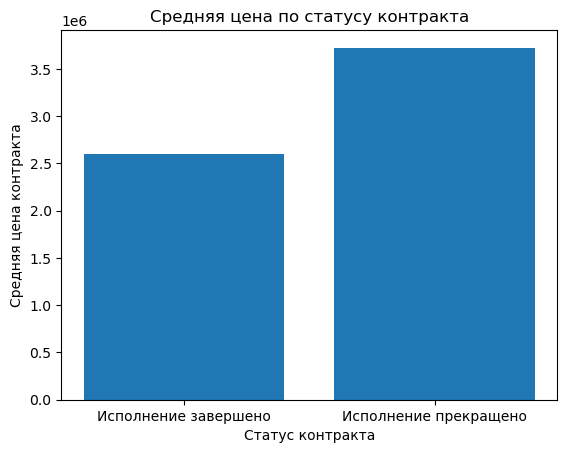

In [57]:
plt.bar(mean_price["Статус контракта"], mean_price["Средняя цена контракта"])
plt.xlabel("Статус контракта")
plt.ylabel("Средняя цена контракта")
plt.title("Средняя цена по статусу контракта")
plt.show()


In [58]:
full_df["Статус контракта"] = (full_df["Статус контракта"] == "Исполнение завершено").astype(int)

full_df["Включение в реестр недобросовестных поставщиков"] = (full_df["Включение в реестр недобросовестных поставщиков"] == "да").astype(int)

In [59]:
okved_1 = full_df.groupby("ОКВЭД", as_index=False).agg({'Доля прекращенных контрактов':'mean', 'Реестровый номер контракта':'nunique'})

In [60]:
# pd.set_option("display.max_rows", None)
okved_1

,ОКВЭД,Доля прекращенных контрактов,Реестровый номер контракта
0,Аренда и лизинг легковых автомобилей и легких ...,0.000000,19
1,"Дезинфекция, дезинсекция, дератизация зданий, ...",0.000000,1
2,Деятельность автомобильного грузового транспорта,0.750000,4
3,Деятельность агентов по оптовой торговле строи...,0.500000,18
4,Деятельность агентств недвижимости за вознагра...,0.000000,1
...,...,...,...
70,Торговля розничная прочими пищевыми продуктами...,0.000000,1
71,"Торговля розничная, осуществляемая непосредств...",0.000000,1
72,Управление недвижимым имуществом за вознагражд...,0.333333,6
73,Управление эксплуатацией жилого фонда за возна...,0.333333,3


In [61]:
okved_group_2 = [
    "Деятельность систем обеспечения безопасности",
    "Деятельность по обеспечению пожарной безопасности",
    "Деятельность охранных служб, в том числе частных",
    "Деятельность в области связи на базе проводных технологий",
    "Деятельность в области защиты информации прочая",
    "Деятельность по обработке данных, предоставление услуг по размещению информации и связанная с этим деятельность",
    "Деятельность консультативная в области компьютерных технологий прочая"
]

okved_1[okved_1["ОКВЭД"].isin(okved_group_2)]

,ОКВЭД,Доля прекращенных контрактов,Реестровый номер контракта
16,Деятельность по обеспечению пожарной безопасности,0.0,1


In [62]:
okved_map = {
    # G0: Строительство и монтаж
    0: [
        "Строительство жилых и нежилых зданий",
        "Строительство водных сооружений",
        "Строительство автомобильных дорог и автомагистралей",
        "Подготовка строительной площадки",
        "Производство земляных работ",
        "Разработка строительных проектов",
        "Работы строительные специализированные прочие, не включенные в другие группировки",
        "Производство электромонтажных работ",
        "Производство санитарно-технических работ, монтаж отопительных систем и систем кондиционирования воздуха",
        "Производство прочих строительно-монтажных работ",
        "Производство штукатурных работ",
        "Производство электромонтажных, санитарно-технических и прочих строительно-монтажных работ",
        "Работы строительные отделочные",
        "Деятельность в области архитектуры",
        "Деятельность, связанная с инженерно-техническим проектированием, управлением проектами строительства, выполнением строительного контроля и авторского надзора",
        "Разборка и снос зданий"
    ],

    # G1: Эксплуатация, клининг, услуги для населения
    1: [
        "Обеспечение работоспособности тепловых сетей",
        "Деятельность по общей уборке зданий",
        "Деятельность по чистке и уборке жилых зданий и нежилых помещений прочая",
        "Деятельность по уборке прочих типов зданий и помещений",
        "Деятельность по чистке и уборке прочая",
        "Деятельность по чистке и уборке прочая, не включенная в другие группировки",
        "Деятельность по комплексному обслуживанию помещений",
        "Деятельность административно-хозяйственная комплексная по обеспечению работы организации",
        "Подметание улиц и уборка снега",
        "Деятельность по благоустройству ландшафта",
        "Дезинфекция, дезинсекция, дератизация зданий, промышленного оборудования",
        "Стирка и химическая чистка текстильных и меховых изделий",
        "Предоставление прочих персональных услуг, не включенных в другие группировки",
        "Деятельность по предоставлению прочих вспомогательных услуг для бизнеса, не включенная в другие группировки",
        "Деятельность по предоставлению прочих персональных услуг",
        "Управление недвижимым имуществом за вознаграждение или на договорной основе",
        "Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе",
        "Управление эксплуатацией нежилого фонда за вознаграждение или на договорной основе",
        "Аренда и управление собственным или арендованным недвижимым имуществом",
        "Аренда и управление собственным или арендованным нежилым недвижимым имуществом",
        "Деятельность агентств недвижимости за вознаграждение или на договорной основе",
        "Покупка и продажа собственного недвижимого имущества",
        "Деятельность больничных организаций",
        "Цветоводство",
        "Деятельность рыночных киосков и торговых палаток по приготовлению пищи"
    ],

    # G2: Безопасность и ИКТ
    2: [
        "Деятельность систем обеспечения безопасности",
        "Деятельность по обеспечению пожарной безопасности",
        "Деятельность охранных служб, в том числе частных",
        "Деятельность в области связи на базе проводных технологий",
        "Деятельность в области защиты информации прочая",
        "Деятельность по обработке данных, предоставление услуг по размещению информации и связанная с этим деятельность",
        "Деятельность консультативная в области компьютерных технологий прочая"
    ],

    # G3: Торговля и логистика
    3: [
        "Торговля оптовая прочими бытовыми товарами",
        "Торговля оптовая неспециализированная",
        "Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием",
        "Торговля оптовая прочими строительными материалами и изделиями",
        "Торговля оптовая бытовыми электротоварами",
        "Торговля оптовая электрической бытовой техникой",
        "Торговля розничная бытовыми электротоварами в специализированных магазинах",
        "Торговля розничная по почте или по информационно-коммуникационной сети Интернет",
        "Торговля розничная, осуществляемая непосредственно при помощи информационно-коммуникационной сети Интернет",
        "Торговля розничная мужской, женской и детской одеждой в специализированных магазинах",
        "Деятельность агентов по оптовой торговле строительными материалами",
        "Деятельность агентов по оптовой торговле универсальным ассортиментом товаров",
        "Деятельность автомобильного грузового транспорта",
        "Деятельность вспомогательная прочая, связанная с перевозками",
        "Деятельность аэропортовая",
        "Деятельность вспомогательная, связанная с воздушным и космическим транспортом"
    ],

    # G4: Профессиональные и экологические услуги
    4: [
        "Обработка и утилизация опасных отходов",
        "Сбор и обработка сточных вод",
        "Производство электроэнергии",
        "Передача электроэнергии и технологическое присоединение к распределительным электросетям",
        "Торговля электроэнергией",
        "Производство, передача и распределение пара и горячей воды; кондиционирование воздуха",
        "Деятельность организаций санитарно-эпидемиологической службы",
        "Консультирование по вопросам коммерческой деятельности и управления",
        "Научные исследования и разработки в области естественных и технических наук прочие",
        "Деятельность профессиональная, научная и техническая прочая, не включенная в другие группировки",
        "Деятельность по управлению холдинг-компаниями",
        "Сертификация продукции, услуг и организаций"
    ]
}

okved_to_class = {okved: group for group, okveds in okved_map.items() for okved in okveds}

full_df["ОКВЭД_класс"] = full_df["ОКВЭД"].map(okved_to_class).fillna(5)

In [63]:
full_df

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ОКВЭД_класс
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.0,0.009439,1.000000,0.563084,1.0
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434,5.0
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434,5.0
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434,5.0
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.491434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,1770982726620001181,7801531045,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ВОСХ...",0,8.724000e+17,07.12.2020,31.12.2021,25067504.12,NaN,Односторонний отказ заказчика от исполнения ко...,Неисполнение обязательств по государственному ...,Да,0,Деятельность прочего сухопутного пассажирского...,NaN,NaN,NaN,2.506750e+07,25067504.12,NaN,1.0,1.0,1.0,0.000000,1.0,1.0,0.000000,NaN,0.491434,5.0
984,1781448847821000003,781415901903,КУЗНЕЦОВ ЕВГЕНИЙ ВЛАДИМИРОВИЧ Индивидуальный п...,0,3.451000e+17,24.12.2020,31.12.2021,1734818.70,144568.22,Соглашение сторон,Соглашение сторон,Нет,0,Деятельность автомобильного грузового транспорта,NaN,NaN,NaN,1.277409e+06,1734818.70,1.285529e+05,2.0,2.0,0.0,0.000000,1.0,0.0,0.000000,0.100636,0.491434,3.0
985,1783806756721000002,7805756850,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЗВЕЗ...",0,1.724000e+17,30.12.2020,31.07.2021,353847.03,NaN,Односторонний отказ заказчика от исполнения ко...,"Существенное нарушение исполнения Контракта, в...",Да,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,1.968512e+05,353847.03,1.806467e+05,5.0,2.0,2.0,0.000000,0.4,0.4,0.000000,0.917681,0.491434,1.0
986,1783806756721000001,7805756850,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЗВЕЗ...",0,1.724000e+17,30.12.2020,31.07.2021,88469.02,NaN,Односторонний отказ заказчика от исполнения ко...,"Существенное нарушение исполнения Контракта, в...",Да,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,1.968512e+05,353847.03,1.806467e+05,5.0,2.0,2.0,0.000000,0.4,0.4,0.000000,0.917681,0.491434,1.0


In [64]:
okved = full_df.groupby("ОКВЭД_класс", as_index=False).agg({'Доля прекращенных контрактов':'mean'})

In [65]:
okved.head()

,ОКВЭД_класс,Доля прекращенных контрактов
0,0.0,0.200000
1,1.0,0.224377
2,2.0,0.000000
3,3.0,0.551724
4,4.0,0.833333


In [66]:
full_df["ЛогЦена"] = np.log1p(full_df["Цена контракта"].clip(lower=0))
full_df["ЛогПрибыль"] = np.log1p(full_df["Прибыль(убыток)"].clip(lower=0))
# full_df["Доля оплаты"] = full_df["Фактически оплачено"]/full_df["Цена контракта"]

scaler = MinMaxScaler()

cols_to_scale = ["ЛогЦена", "ЛогПрибыль"]

full_df[cols_to_scale] = scaler.fit_transform(full_df[cols_to_scale])


In [67]:
full_df.describe()

,Реестровый номер контракта,Статус контракта,Номер извещения,Цена контракта,Фактически оплачено,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ОКВЭД_класс,ЛогЦена,ЛогПрибыль
count,9.880000e+02,988.000000,9.800000e+02,9.880000e+02,9.450000e+02,988.000000,4.860000e+02,4.860000e+02,4.860000e+02,9.880000e+02,9.880000e+02,9.780000e+02,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,978.000000,988.000000,988.000000,988.000000,486.000000
mean,2.487336e+18,0.781377,3.445041e+17,2.847025e+06,2.706403e+06,0.098178,6.429823e+07,5.827397e+07,6.024260e+06,2.847025e+06,6.612276e+06,2.664341e+06,11.196356,2.393725,1.496964,-0.014585,0.218623,0.112348,0.186972,0.930276,0.538042,1.629555,0.640762,0.664389
std,4.965338e+17,0.413522,1.327338e+17,6.818175e+06,6.644198e+06,0.297706,9.451631e+07,9.018083e+07,1.091166e+07,5.134015e+06,1.149421e+07,4.794692e+06,12.896907,4.032774,3.475342,1.825208,0.271966,0.194882,1.410361,0.144656,0.062549,1.537909,0.124475,0.331906
min,1.470000e+18,0.000000,1.451000e+17,2.688800e+02,2.688800e+02,0.000000,0.000000e+00,0.000000e+00,-4.759000e+06,7.806000e+03,7.806000e+03,3.931440e+03,1.000000,0.000000,0.000000,-56.854839,0.000000,0.000000,0.000000,0.015682,0.327622,0.000000,0.000000,0.000000
25%,1.783000e+18,1.000000,3.452000e+17,3.747980e+05,3.259865e+05,0.000000,1.403800e+07,1.229500e+07,2.960000e+05,5.824534e+05,1.159007e+06,5.289566e+05,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917681,0.491434,1.000000,0.567845,0.688240
50%,2.780803e+18,1.000000,3.722000e+17,1.231252e+06,1.073328e+06,0.000000,3.646800e+07,2.529300e+07,2.005000e+06,1.373345e+06,2.999963e+06,1.332212e+06,7.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.992370,0.491434,1.000000,0.661182,0.792749
75%,2.781605e+18,1.000000,3.722002e+17,2.632183e+06,2.492553e+06,0.000000,7.220925e+07,7.052600e+07,7.966000e+06,2.573887e+06,6.907343e+06,2.573887e+06,12.500000,3.000000,1.000000,0.063745,0.391304,0.200000,0.049327,1.000000,0.595800,1.000000,0.720804,0.868114
max,4.784029e+18,1.000000,8.725000e+17,9.235670e+07,9.103919e+07,1.000000,1.066776e+09,1.058850e+09,8.906200e+07,6.744398e+07,9.235670e+07,6.127358e+07,46.000000,18.000000,16.000000,0.991066,1.000000,1.000000,23.022845,1.253872,0.989755,5.000000,1.000000,1.000000


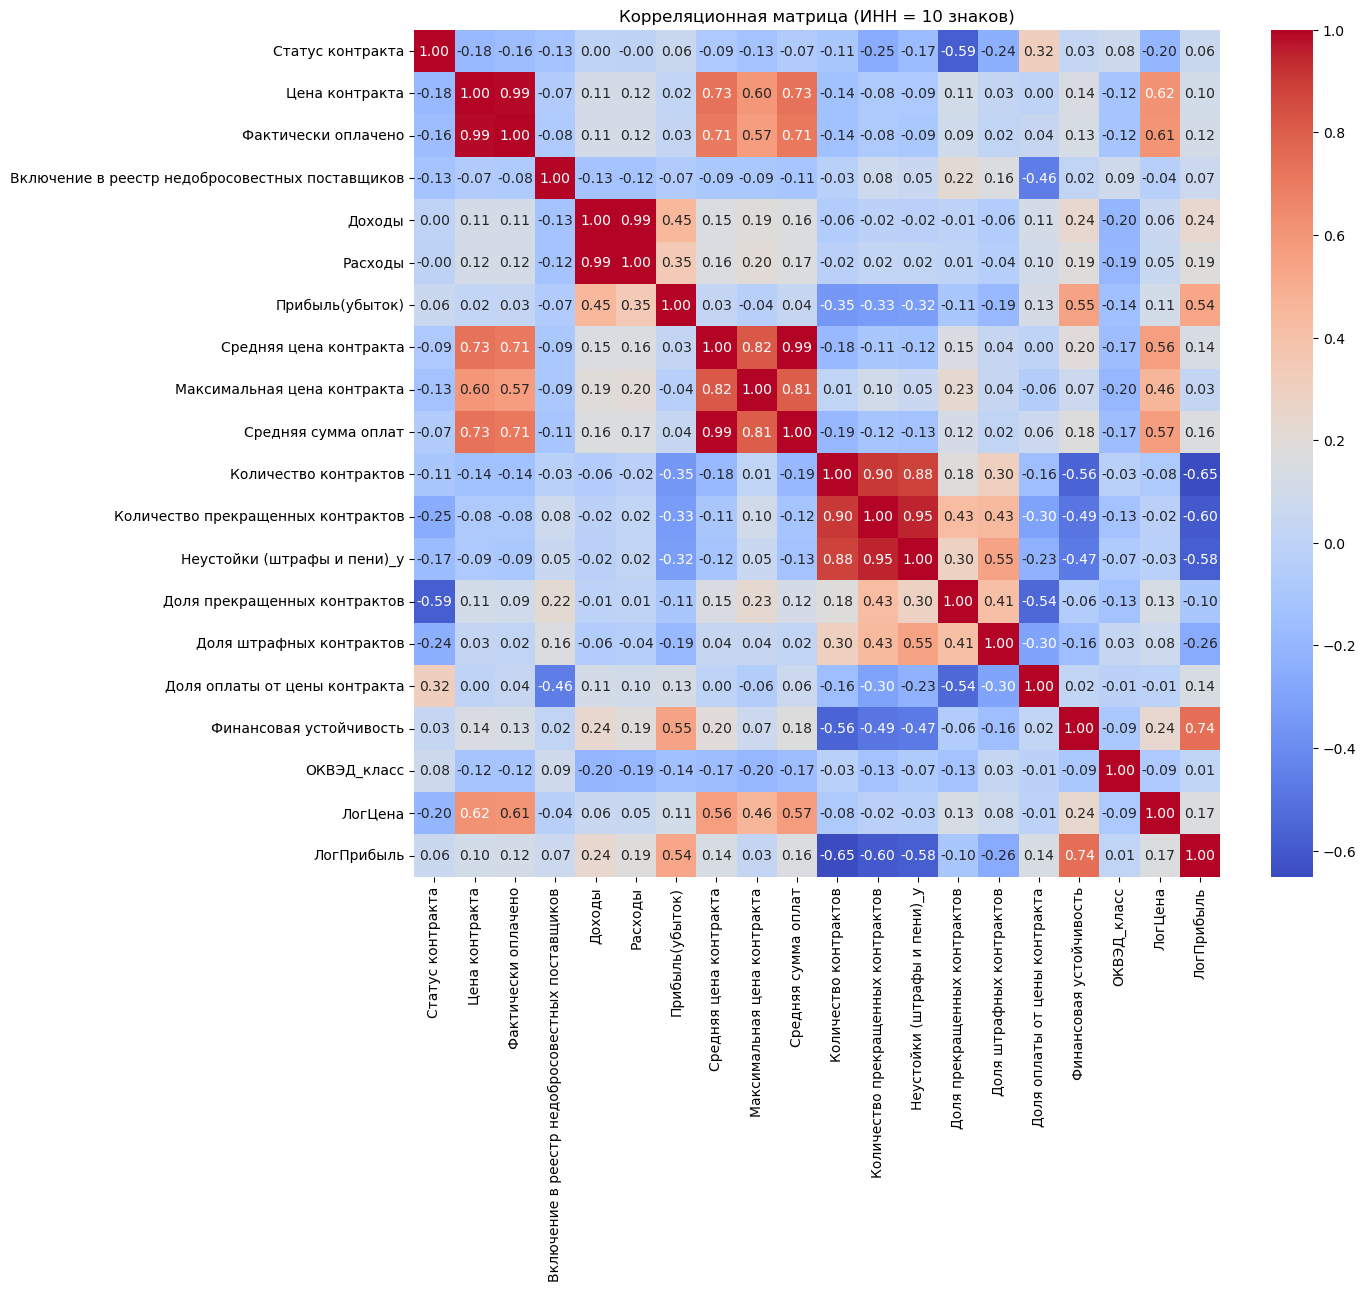

In [68]:
filtered_df = full_df[
    (full_df["ИНН исполнителя"].astype(str).str.len() == 10) &
    (full_df["Доходы"].notna()) &
    (full_df["Расходы"].notna())
]


numeric_df = filtered_df.select_dtypes(include=["number"])

numeric_df = numeric_df.drop(["Реестровый номер контракта", "Номер извещения", "Рентабельность продаж", "Доля контракта от доходов"], axis=1)

num_cols = numeric_df.columns

scaler = MinMaxScaler()

numeric_df[num_cols] = scaler.fit_transform(numeric_df[num_cols])




corr_matrix = numeric_df.corr()

plt.figure(figsize=(13,11))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица (ИНН = 10 знаков)")
plt.show()


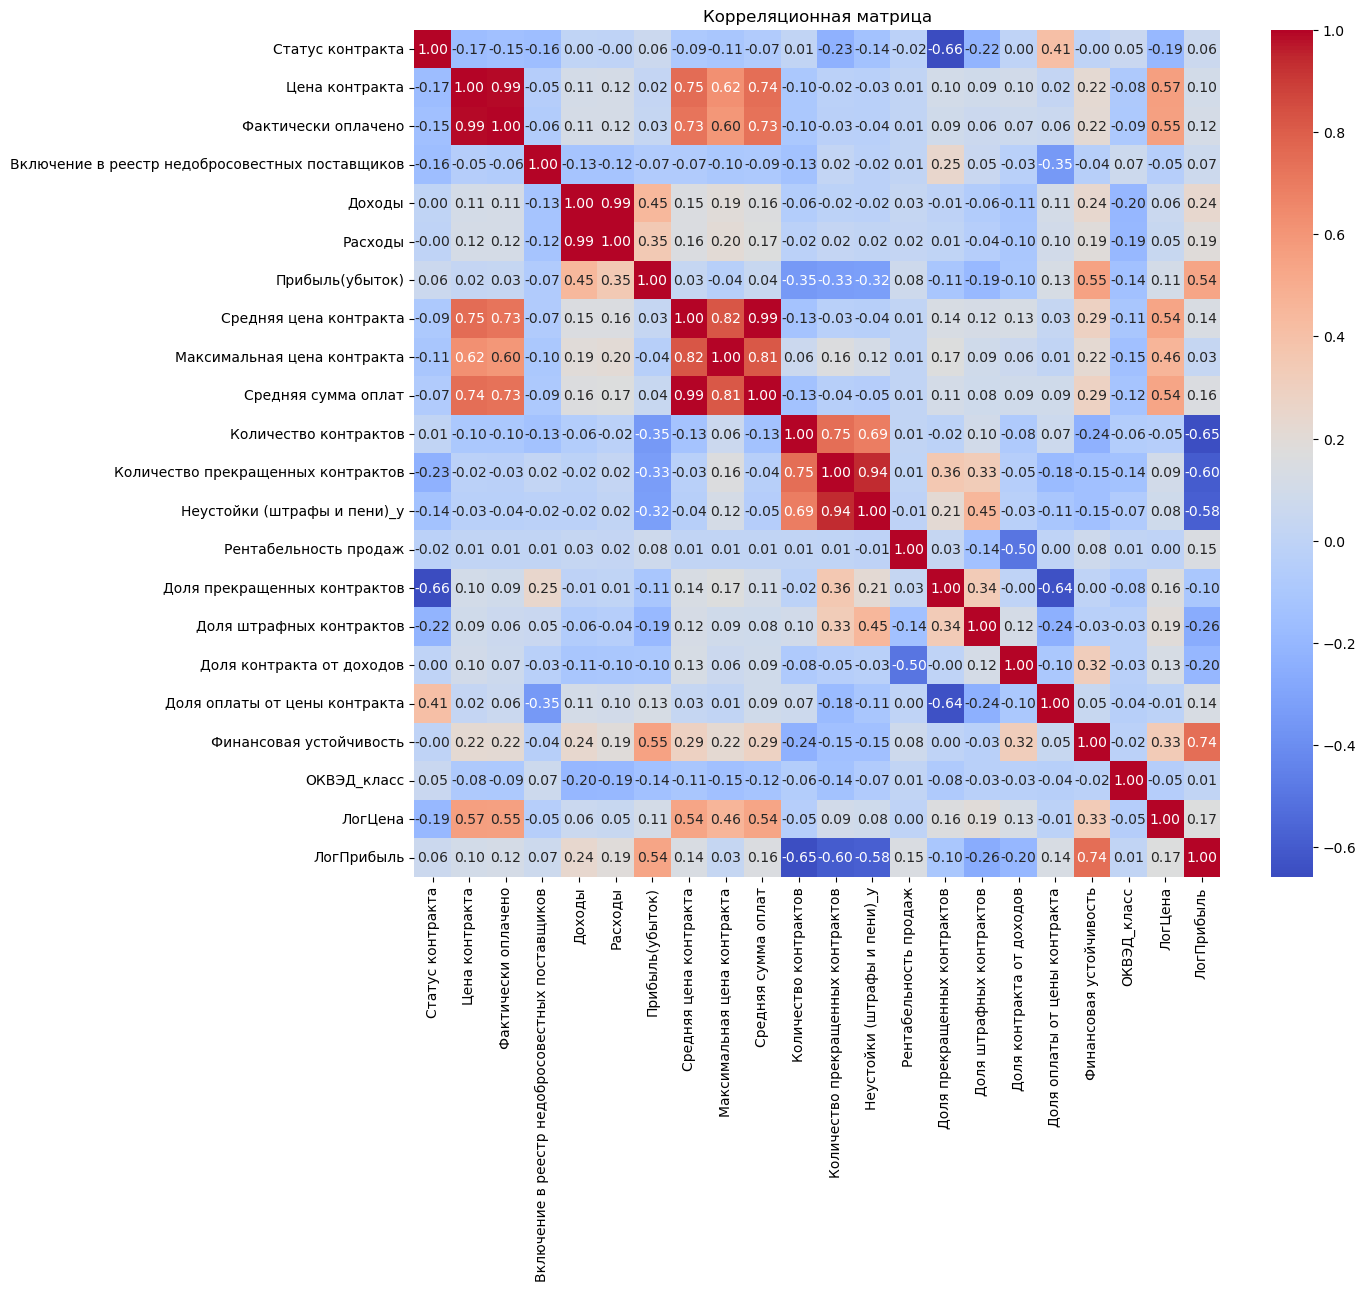

In [69]:
numeric_df = full_df.select_dtypes(include=["number"])
numeric_df = numeric_df.drop(["Реестровый номер контракта", "Номер извещения"], axis = 1)

corr_matrix = numeric_df.corr()

plt.figure(figsize=(13,11))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица")
plt.show()

In [70]:
full_df = pd.get_dummies(full_df, columns = ["ОКВЭД_класс"], drop_first = True)


In [71]:
full_df.head()

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.0,0.009439,1.0,0.563084,0.490508,0.705502,1,0,0,0,0
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.401556,NaN,0,0,0,0,1
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.643381,NaN,0,0,0,0,1
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.646395,NaN,0,0,0,0,1
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.572365,NaN,0,0,0,0,0


In [72]:
for_mean_penalties_df = full_df.copy()

for_mean_penalties_df["Средний процент недоплаты"] = 1 -(for_mean_penalties_df["Фактически оплачено"] / for_mean_penalties_df["Цена контракта"]) 

In [73]:
for_mean_penalties_df.head()

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.0,0.009439,1.0,0.563084,0.490508,0.705502,1,0,0,0,0,0.0
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.401556,NaN,0,0,0,0,1,0.0
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.643381,NaN,0,0,0,0,1,0.0
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.646395,NaN,0,0,0,0,1,0.0
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.572365,NaN,0,0,0,0,0,0.0


In [74]:
mean_penalties_df = for_mean_penalties_df.groupby('ИНН исполнителя', as_index=False).agg({'Средний процент недоплаты':'mean'})

In [75]:
mean_penalties_df.head(10)

,ИНН исполнителя,Средний процент недоплаты
0,1001232969,0.143731
1,1001334880,NaN
2,110110067712,0.000000
3,1101159127,0.000000
4,1435361389,0.719321
5,165118595909,0.000000
6,183236617788,0.828773
7,210403215410,0.211980
8,211301376106,0.000331
9,220403394846,0.008373


In [76]:
full_df = pd.merge(full_df, mean_penalties_df, on="ИНН исполнителя", how="left")

In [77]:
full_df.head()

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,139890.00,1.398900e+05,1.0,0.0,0.0,0.027395,0.0,0.0,0.009439,1.0,0.563084,0.490508,0.705502,1,0,0,0,0,0.0
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.401556,NaN,0,0,0,0,1,0.0
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.643381,NaN,0,0,0,0,1,0.0
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,3242999.41,1.332212e+06,8.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.646395,NaN,0,0,0,0,1,0.0
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,397013.75,3.970138e+05,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.491434,0.572365,NaN,0,0,0,0,0,0.0


In [78]:
#---------------------
#
#Модели
#
#---------------------

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [80]:
full_df.columns

Index(['Реестровый номер контракта', 'ИНН исполнителя',
       'Наименование исполнителя', 'Статус контракта', 'Номер извещения',
       'Дата заключения контракта', 'Дата окончания исполнения контракта',
       'Цена контракта', 'Фактически оплачено',
       'Основание расторжения контракта', 'Причина расторжения контракта',
       'Неустойки (штрафы и пени)_x',
       'Включение в реестр недобросовестных поставщиков', 'ОКВЭД', 'Доходы',
       'Расходы', 'Прибыль(убыток)', 'Средняя цена контракта',
       'Максимальная цена контракта', 'Средняя сумма оплат',
       'Количество контрактов', 'Количество прекращенных контрактов',
       'Неустойки (штрафы и пени)_y', 'Рентабельность продаж',
       'Доля прекращенных контрактов', 'Доля штрафных контрактов',
       'Доля контракта от доходов', 'Доля оплаты от цены контракта',
       'Финансовая устойчивость', 'ЛогЦена', 'ЛогПрибыль', 'ОКВЭД_класс_1.0',
       'ОКВЭД_класс_2.0', 'ОКВЭД_класс_3.0', 'ОКВЭД_класс_4.0',
       'ОКВЭД_класс_5.

In [81]:
full_df.describe()

,Реестровый номер контракта,Статус контракта,Номер извещения,Цена контракта,Фактически оплачено,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты
count,9.880000e+02,988.000000,9.800000e+02,9.880000e+02,9.450000e+02,988.000000,4.860000e+02,4.860000e+02,4.860000e+02,9.880000e+02,9.880000e+02,9.780000e+02,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,978.000000,988.000000,988.000000,486.000000,988.000000,988.000000,988.000000,988.000000,988.000000,978.000000
mean,2.487336e+18,0.781377,3.445041e+17,2.847025e+06,2.706403e+06,0.098178,6.429823e+07,5.827397e+07,6.024260e+06,2.847025e+06,6.612276e+06,2.664341e+06,11.196356,2.393725,1.496964,-0.014585,0.218623,0.112348,0.186972,0.930276,0.538042,0.640762,0.664389,0.730769,0.001012,0.029352,0.006073,0.156883,0.054271
std,4.965338e+17,0.413522,1.327338e+17,6.818175e+06,6.644198e+06,0.297706,9.451631e+07,9.018083e+07,1.091166e+07,5.134015e+06,1.149421e+07,4.794692e+06,12.896907,4.032774,3.475342,1.825208,0.271966,0.194882,1.410361,0.144656,0.062549,0.124475,0.331906,0.443785,0.031814,0.168877,0.077731,0.363874,0.127012
min,1.470000e+18,0.000000,1.451000e+17,2.688800e+02,2.688800e+02,0.000000,0.000000e+00,0.000000e+00,-4.759000e+06,7.806000e+03,7.806000e+03,3.931440e+03,1.000000,0.000000,0.000000,-56.854839,0.000000,0.000000,0.000000,0.015682,0.327622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.783000e+18,1.000000,3.452000e+17,3.747980e+05,3.259865e+05,0.000000,1.403800e+07,1.229500e+07,2.960000e+05,5.824534e+05,1.159007e+06,5.289566e+05,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917681,0.491434,0.567845,0.688240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.780803e+18,1.000000,3.722000e+17,1.231252e+06,1.073328e+06,0.000000,3.646800e+07,2.529300e+07,2.005000e+06,1.373345e+06,2.999963e+06,1.332212e+06,7.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.992370,0.491434,0.661182,0.792749,1.000000,0.000000,0.000000,0.000000,0.000000,0.008572
75%,2.781605e+18,1.000000,3.722002e+17,2.632183e+06,2.492553e+06,0.000000,7.220925e+07,7.052600e+07,7.966000e+06,2.573887e+06,6.907343e+06,2.573887e+06,12.500000,3.000000,1.000000,0.063745,0.391304,0.200000,0.049327,1.000000,0.595800,0.720804,0.868114,1.000000,0.000000,0.000000,0.000000,0.000000,0.033333
max,4.784029e+18,1.000000,8.725000e+17,9.235670e+07,9.103919e+07,1.000000,1.066776e+09,1.058850e+09,8.906200e+07,6.744398e+07,9.235670e+07,6.127358e+07,46.000000,18.000000,16.000000,0.991066,1.000000,1.000000,23.022845,1.253872,0.989755,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960526


In [132]:
# features = ["Доля прекращенных контрактов", "Количество прекращенных контрактов", "ЛогЦена", "Включение в реестр недобросовестных поставщиков"]
features = [    
       'Фактически оплачено',
        'Прибыль(убыток)',
       'Максимальная цена контракта',
       'Количество контрактов', 
        'Количество прекращенных контрактов',
       'Доля прекращенных контрактов', 
        'Доля штрафных контрактов', 
        'ЛогЦена']

# features = [    
#        'Максимальная цена контракта',
#        'Количество контрактов', 'Количество прекращенных контрактов',
#        'Доля прекращенных контрактов', 'Доля штрафных контрактов', 'ЛогЦена', 'Доля оплаты от цены контракта', 'Финансовая устойчивость']


scaler = MinMaxScaler()

full_df[features] = scaler.fit_transform(full_df[features])

X = full_df[features].fillna(0)
y = full_df["Статус контракта"]

In [83]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 0 to 987
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Реестровый номер контракта                       988 non-null    int64  
 1   ИНН исполнителя                                  988 non-null    object 
 2   Наименование исполнителя                         988 non-null    object 
 3   Статус контракта                                 988 non-null    int32  
 4   Номер извещения                                  980 non-null    float64
 5   Дата заключения контракта                        988 non-null    object 
 6   Дата окончания исполнения контракта              988 non-null    object 
 7   Цена контракта                                   988 non-null    float64
 8   Фактически оплачено                              945 non-null    float64
 9   Основание расторжения контракта 

In [84]:
X

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость
0,0.001430,0.000000,0.000000,0.0,0.0,0.490508,0.794965,0.355612
1,0.035032,0.155556,0.000000,0.0,0.0,0.401556,0.794965,0.247399
2,0.035032,0.155556,0.000000,0.0,0.0,0.643381,0.794965,0.247399
3,0.035032,0.155556,0.000000,0.0,0.0,0.646395,0.794965,0.247399
4,0.004215,0.000000,0.000000,0.0,0.0,0.572365,0.794965,0.247399
...,...,...,...,...,...,...,...,...
983,0.271359,0.000000,0.055556,1.0,1.0,0.897664,0.000000,0.247399
984,0.018701,0.022222,0.111111,1.0,0.0,0.688088,0.068611,0.247399
985,0.003747,0.088889,0.111111,0.4,0.4,0.563332,0.728482,0.247399
986,0.003747,0.088889,0.111111,0.4,0.4,0.454552,0.728482,0.247399


In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [137]:
y_pred_tr = model.predict(X_train)
y_prob_tr = model.predict_proba(X_train)[:, 1]

In [87]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.49      0.59        65
           1       0.87      0.95      0.91       232

    accuracy                           0.85       297
   macro avg       0.81      0.72      0.75       297
weighted avg       0.84      0.85      0.84       297



In [88]:
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.73      0.48      0.58       151
           1       0.87      0.95      0.91       540

    accuracy                           0.85       691
   macro avg       0.80      0.72      0.74       691
weighted avg       0.84      0.85      0.84       691



In [89]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

y_pred_tr = model.predict(X_train)
y_prob_tr = model.predict_proba(X_train)[:, 1]


threshold = 0.3
y_pred_custom = (y_prob >= threshold).astype(int)

y_pred_tr_custom = (y_prob_tr >= threshold).astype(int)


In [90]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63        65
           1       0.92      0.82      0.87       232

    accuracy                           0.80       297
   macro avg       0.73      0.79      0.75       297
weighted avg       0.84      0.80      0.82       297



In [91]:
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.57      0.83      0.67       151
           1       0.94      0.82      0.88       540

    accuracy                           0.82       691
   macro avg       0.76      0.83      0.78       691
weighted avg       0.86      0.82      0.84       691



In [92]:
print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62        65
           1       0.90      0.89      0.89       232

    accuracy                           0.83       297
   macro avg       0.75      0.76      0.76       297
weighted avg       0.83      0.83      0.83       297



In [93]:
coefs = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_[0]
})

print(coefs)

                              feature      coef
0         Максимальная цена контракта  0.656045
1               Количество контрактов  0.248634
2  Количество прекращенных контрактов -1.179554
3        Доля прекращенных контрактов -5.664892
4            Доля штрафных контрактов -0.095823
5                             ЛогЦена -2.259254
6       Доля оплаты от цены контракта  1.039019
7             Финансовая устойчивость  0.151958


In [94]:
y_prob_tr

array([0.77538264, 0.16658543, 0.16157738, 0.01728569, 0.94403583,
       0.87243585, 0.84033832, 0.61459346, 0.76314565, 0.87152177,
       0.91195466, 0.35667162, 0.86514266, 0.82759094, 0.76106853,
       0.76154903, 0.74272627, 0.88405821, 0.91022919, 0.37509894,
       0.86473272, 0.89346187, 0.38732637, 0.87363557, 0.13694473,
       0.01427806, 0.44755746, 0.84737522, 0.87156664, 0.44899348,
       0.01615916, 0.91453565, 0.87255919, 0.89960407, 0.91788377,
       0.88052553, 0.75048844, 0.14894113, 0.80683949, 0.65765885,
       0.44488655, 0.88139053, 0.79700149, 0.15142343, 0.80655467,
       0.85710804, 0.85413747, 0.59162007, 0.85655569, 0.86272571,
       0.60438379, 0.76113568, 0.660438  , 0.87220517, 0.84176975,
       0.61634514, 0.09777485, 0.90847875, 0.92766288, 0.62854963,
       0.89159841, 0.88648753, 0.37400308, 0.89719826, 0.7629627 ,
       0.82334546, 0.92040217, 0.185652  , 0.92772734, 0.87648234,
       0.90539764, 0.87066958, 0.81828544, 0.90978395, 0.90779

In [95]:
X_train

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость
689,0.026477,0.133333,0.055556,0.142857,0.000000,0.612990,0.791928,0.397144
354,0.036410,0.377778,0.500000,0.500000,0.333333,0.666718,0.581662,0.416510
285,0.010816,0.044444,0.111111,0.666667,0.000000,0.503088,0.721726,0.425964
549,0.004266,0.022222,0.111111,1.000000,0.000000,0.543406,0.358346,0.247399
830,0.000011,0.000000,0.000000,0.000000,0.000000,0.273911,0.794965,0.350984
...,...,...,...,...,...,...,...,...
649,0.038739,0.066667,0.000000,0.000000,0.250000,0.690695,0.794965,0.482747
710,0.138075,1.000000,1.000000,0.391304,0.347826,0.565072,0.697035,0.247468
236,0.025654,0.044444,0.000000,0.000000,0.000000,0.712800,0.794759,0.247399
513,0.033341,0.066667,0.055556,0.250000,0.250000,0.733308,0.777519,0.433499


In [96]:
y_prob_tr

array([0.77538264, 0.16658543, 0.16157738, 0.01728569, 0.94403583,
       0.87243585, 0.84033832, 0.61459346, 0.76314565, 0.87152177,
       0.91195466, 0.35667162, 0.86514266, 0.82759094, 0.76106853,
       0.76154903, 0.74272627, 0.88405821, 0.91022919, 0.37509894,
       0.86473272, 0.89346187, 0.38732637, 0.87363557, 0.13694473,
       0.01427806, 0.44755746, 0.84737522, 0.87156664, 0.44899348,
       0.01615916, 0.91453565, 0.87255919, 0.89960407, 0.91788377,
       0.88052553, 0.75048844, 0.14894113, 0.80683949, 0.65765885,
       0.44488655, 0.88139053, 0.79700149, 0.15142343, 0.80655467,
       0.85710804, 0.85413747, 0.59162007, 0.85655569, 0.86272571,
       0.60438379, 0.76113568, 0.660438  , 0.87220517, 0.84176975,
       0.61634514, 0.09777485, 0.90847875, 0.92766288, 0.62854963,
       0.89159841, 0.88648753, 0.37400308, 0.89719826, 0.7629627 ,
       0.82334546, 0.92040217, 0.185652  , 0.92772734, 0.87648234,
       0.90539764, 0.87066958, 0.81828544, 0.90978395, 0.90779

In [97]:
X_train_prop = X_train.copy()
X_train_prop["probability"] = y_prob_tr

In [98]:
X_train_prop.head()

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость,probability
689,0.026477,0.133333,0.055556,0.142857,0.000000,0.612990,0.791928,0.397144,0.775383
354,0.036410,0.377778,0.500000,0.500000,0.333333,0.666718,0.581662,0.416510,0.166585
285,0.010816,0.044444,0.111111,0.666667,0.000000,0.503088,0.721726,0.425964,0.161577
549,0.004266,0.022222,0.111111,1.000000,0.000000,0.543406,0.358346,0.247399,0.017286
830,0.000011,0.000000,0.000000,0.000000,0.000000,0.273911,0.794965,0.350984,0.944036


In [99]:
X_test_prop = X_test.copy()
X_test_prop["probability"] = y_prob

In [100]:
X_test_prop.head()

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость,probability
607,0.000311,0.022222,0.000000,0.000000,0.000000,0.385063,0.794965,0.436956,0.930417
189,0.004788,0.066667,0.000000,0.000000,0.000000,0.582195,0.794965,0.247399,0.894063
249,0.063704,0.044444,0.000000,0.000000,0.000000,0.784021,0.794965,0.349992,0.848858
665,0.106474,0.288889,0.277778,0.357143,0.071429,0.730634,0.761380,0.402757,0.389496
205,0.022811,0.155556,0.055556,0.125000,0.000000,0.568706,0.794965,0.348351,0.808304


In [101]:
X_res = pd.concat([X_train_prop, X_test_prop])

In [102]:
X_res

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость,probability
689,0.026477,0.133333,0.055556,0.142857,0.000000,0.612990,0.791928,0.397144,0.775383
354,0.036410,0.377778,0.500000,0.500000,0.333333,0.666718,0.581662,0.416510,0.166585
285,0.010816,0.044444,0.111111,0.666667,0.000000,0.503088,0.721726,0.425964,0.161577
549,0.004266,0.022222,0.111111,1.000000,0.000000,0.543406,0.358346,0.247399,0.017286
830,0.000011,0.000000,0.000000,0.000000,0.000000,0.273911,0.794965,0.350984,0.944036
...,...,...,...,...,...,...,...,...,...
53,0.043843,0.088889,0.055556,0.200000,0.200000,0.754748,0.629850,0.247399,0.595080
231,0.937510,0.088889,0.166667,0.600000,0.000000,0.807302,0.656875,0.393466,0.186180
986,0.003747,0.088889,0.111111,0.400000,0.400000,0.454552,0.728482,0.247399,0.480441
394,0.138075,1.000000,1.000000,0.391304,0.347826,0.691303,0.697035,0.247468,0.209922


In [103]:
full_df_prob = pd.concat([full_df, X_res["probability"]], axis = 1)

In [104]:
full_df_prob.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты,probability
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,0.001430,1.398900e+05,0.000000,0.000000,0.0,0.027395,0.000000,0.000000,0.009439,0.794965,0.355612,0.490508,0.705502,1,0,0,0,0,0.000000,0.911955
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.401556,NaN,0,0,0,0,1,0.000000,0.929758
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.643381,NaN,0,0,0,0,1,0.000000,0.884590
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.646395,NaN,0,0,0,0,1,0.000000,0.883893
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,0.004215,3.970138e+05,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.572365,NaN,0,0,0,0,0,0.000000,0.894560
5,2781106636524000026,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,83460.00,83460.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.449978,NaN,1,0,0,0,0,0.033333,0.883364
6,2781102288024000029,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,171080.00,171080.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.506303,NaN,1,0,0,0,0,0.033333,0.869600
7,2781106763324000025,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,82680.00,82680.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.449241,NaN,1,0,0,0,0,0.033333,0.883535
8,2781102285824000032,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,83616.00,83616.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,Na

In [105]:
full_df_prob.head(50)

,Реестровый номер контракта,ИНН исполнителя,Наименование исполнителя,Статус контракта,Номер извещения,Дата заключения контракта,Дата окончания исполнения контракта,Цена контракта,Фактически оплачено,Основание расторжения контракта,Причина расторжения контракта,Неустойки (штрафы и пени)_x,Включение в реестр недобросовестных поставщиков,ОКВЭД,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты,probability
0,2780804522025000020,7820303220,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",1,3.722002e+17,11.08.2025,30.09.2025,139890.00,139890.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,14820000.0,14414000.0,406000.0,1.398900e+05,0.001430,1.398900e+05,0.000000,0.000000,0.0,0.027395,0.000000,0.000000,0.009439,0.794965,0.355612,0.490508,0.705502,1,0,0,0,0,0.000000,0.911955
1,2782200215525000008,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,25.02.2025,31.12.2025,45028.80,45028.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.401556,NaN,0,0,0,0,1,0.000000,0.929758
2,2782544053425000023,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,12.05.2025,31.12.2025,981363.80,981363.80,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.643381,NaN,0,0,0,0,1,0.000000,0.884590
3,2782544053424000058,782031876507,БАРАБАНОВ ИГОРЬ СЕРГЕЕВИЧ Индивидуальный предп...,1,3.722001e+17,04.06.2024,31.12.2024,1019797.77,1019797.77,NaN,NaN,Нет,0,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,1.332212e+06,0.035032,1.332212e+06,0.155556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.646395,NaN,0,0,0,0,1,0.000000,0.883893
4,2780503024025000210,781617676312,ЧЕКРЕНЕВ ИГОРЬ АЛЕКСАНДРОВИЧ Индивидуальный пр...,1,3.721000e+17,16.06.2025,15.12.2025,397013.75,397013.75,NaN,NaN,Нет,0,Производство электромонтажных работ,NaN,NaN,NaN,3.970138e+05,0.004215,3.970138e+05,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794965,0.247399,0.572365,NaN,0,0,0,0,0,0.000000,0.894560
5,2781106636524000026,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,83460.00,83460.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.449978,NaN,1,0,0,0,0,0.033333,0.883364
6,2781102288024000029,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,171080.00,171080.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.506303,NaN,1,0,0,0,0,0.033333,0.869600
7,2781106763324000025,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,82680.00,82680.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,NaN,NaN,8.701237e+04,0.001768,8.467237e+04,0.311111,0.055556,0.0,0.000000,0.066667,0.000000,0.000000,0.773246,0.247399,0.449241,NaN,1,0,0,0,0,0.033333,0.883535
8,2781102285824000032,246900316697,ОМАРОВА КРИСТИНА СЕРГЕЕВНА Индивидуальный пред...,1,1.722000e+17,19.08.2024,31.12.2025,83616.00,83616.00,NaN,NaN,Нет,0,Деятельность по чистке и уборке жилых зданий и...,NaN,Na

In [106]:
group_full_df_prob = full_df_prob.groupby('ИНН исполнителя', as_index=False).agg(probability_mean=('probability', 'mean'))

In [107]:
group_full_df_prob.drop(0, axis=0, inplace=True)

In [108]:
group_full_df_prob.reset_index(drop=True, inplace=True)

In [109]:
group_full_df_prob.head()

,ИНН исполнителя,probability_mean
0,1001334880,0.008550
1,110110067712,0.859914
2,1101159127,0.914023
3,1435361389,0.013438
4,165118595909,0.928653


In [110]:
group_full_df_prob.sort_values(by = "probability_mean", ascending = False)["probability_mean"].unique()

array([0.94438026, 0.94403583, 0.943066  , 0.9384357 , 0.9381974 ,
       0.93794368, 0.93757348, 0.9315766 , 0.93141234, 0.93056177,
       0.93015225, 0.92913759, 0.92865328, 0.92773141, 0.92772734,
       0.92768266, 0.92693548, 0.92678202, 0.9264461 , 0.92564917,
       0.92548769, 0.92460485, 0.92323086, 0.92277622, 0.92227978,
       0.92194851, 0.91542582, 0.9154175 , 0.91402256, 0.91340656,
       0.91319007, 0.91277829, 0.91195466, 0.91156697, 0.90945382,
       0.90901321, 0.90879802, 0.90806328, 0.90779024, 0.90695289,
       0.90690834, 0.90603519, 0.90583658, 0.90574898, 0.90569821,
       0.90473526, 0.90412431, 0.90388425, 0.90330526, 0.90280034,
       0.90181982, 0.90173327, 0.90154135, 0.89960407, 0.89788604,
       0.89703971, 0.89455975, 0.89408882, 0.89355698, 0.8931411 ,
       0.89270698, 0.89256252, 0.89232423, 0.89208866, 0.89197802,
       0.89140024, 0.89137278, 0.8908842 , 0.89016133, 0.88879634,
       0.88870324, 0.88842959, 0.88836398, 0.8879785 , 0.88785

In [111]:
first_df_merge_prob = pd.merge(first_df, group_full_df_prob, on = "ИНН исполнителя", how = "left")

In [112]:
probability_df = first_df_merge_prob.loc[first_df_merge_prob["Максимальная цена контракта"]>26000000].sort_values(by = ["probability_mean", "Средняя цена контракта"], ascending = False)

In [113]:
probability_df

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков,probability_mean
175,7810013071,5.985304e+07,1.496326e+07,30066815.39,5.710486e+07,1.427621e+07,4,154123000.0,137329000.0,16794000.0,0,0,0,0.862122
234,7816274834,3.905837e+07,1.301946e+07,29902782.73,3.829089e+07,1.276363e+07,3,85010000.0,74715000.0,10295000.0,0,1,0,0.856810
81,665209071864,3.632068e+07,3.632068e+07,36320683.85,3.604015e+07,3.604015e+07,1,NaN,NaN,NaN,0,0,0,0.830085
157,7806272267,1.059515e+08,1.324394e+07,38180356.63,1.052506e+08,1.315632e+07,8,249909000.0,241730000.0,8179000.0,2,0,0,0.597912
276,7842459510,1.040658e+08,2.081316e+07,92356699.83,1.020224e+08,2.040449e+07,5,80677000.0,78251000.0,2426000.0,2,0,0,0.491169
174,7810010730,7.484978e+07,2.494993e+07,26597917.69,7.477861e+07,2.492620e+07,3,91183000.0,86107000.0,5076000.0,1,0,0,0.419424
273,7842023467,6.905574e+07,1.381115e+07,35492981.11,6.751298e+07,1.350260e+07,5,224425000.0,219187000.0,5238000.0,2,1,0,0.386720
94,772774274560,9.143790e+07,1.306256e+07,26791283.24,9.131812e+07,1.304545e+07,7,NaN,NaN,NaN,3,3,0,0.303370
167,7806538767,4.324055e+07,2.162028e+07,37544192.07,3.795084e+07,1.897542e+07,2,36968000.0,30686000.0,6282000.0,1,1,0,0.223979
272,7841432932,1.348880e+08,6.744398e+07,70904664.13,1.225472e+08,6.127358e+07,2,113141000.0,110671000.0,2470000.0,1,1,0,0.220582


In [114]:
probability_df[["ИНН исполнителя", "probability_mean"]].reset_index(drop=True)

,ИНН исполнителя,probability_mean
0,7810013071,0.862122
1,7816274834,0.856810
2,665209071864,0.830085
3,7806272267,0.597912
4,7842459510,0.491169
5,7810010730,0.419424
6,7842023467,0.386720
7,772774274560,0.303370
8,7806538767,0.223979
9,7841432932,0.220582


In [115]:
X_train_prop

,Максимальная цена контракта,Количество контрактов,Количество прекращенных контрактов,Доля прекращенных контрактов,Доля штрафных контрактов,ЛогЦена,Доля оплаты от цены контракта,Финансовая устойчивость,probability
689,0.026477,0.133333,0.055556,0.142857,0.000000,0.612990,0.791928,0.397144,0.775383
354,0.036410,0.377778,0.500000,0.500000,0.333333,0.666718,0.581662,0.416510,0.166585
285,0.010816,0.044444,0.111111,0.666667,0.000000,0.503088,0.721726,0.425964,0.161577
549,0.004266,0.022222,0.111111,1.000000,0.000000,0.543406,0.358346,0.247399,0.017286
830,0.000011,0.000000,0.000000,0.000000,0.000000,0.273911,0.794965,0.350984,0.944036
...,...,...,...,...,...,...,...,...,...
649,0.038739,0.066667,0.000000,0.000000,0.250000,0.690695,0.794965,0.482747,0.872348
710,0.138075,1.000000,1.000000,0.391304,0.347826,0.565072,0.697035,0.247468,0.261110
236,0.025654,0.044444,0.000000,0.000000,0.000000,0.712800,0.794759,0.247399,0.863634
513,0.033341,0.066667,0.055556,0.250000,0.250000,0.733308,0.777519,0.433499,0.578033


In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [117]:
pca_features = ["Доходы", "Прибыль(убыток)", "Максимальная цена контракта", "Количество контрактов", "Рентабельность продаж", "Финансовая устойчивость"]

In [118]:
s = pd.to_numeric(full_df["Рентабельность продаж"], errors="coerce")

m = s[np.isfinite(s)].mean()

full_df["Рентабельность продаж"].replace([np.nan,np.inf,-np.inf], m, inplace = True)

In [119]:
X_pca = full_df[pca_features].fillna(0)
y_pca = full_df["Статус контракта"]

In [120]:
full_df.describe()

,Реестровый номер контракта,Статус контракта,Номер извещения,Цена контракта,Фактически оплачено,Включение в реестр недобросовестных поставщиков,Доходы,Расходы,Прибыль(убыток),Средняя цена контракта,Максимальная цена контракта,Средняя сумма оплат,Количество контрактов,Количество прекращенных контрактов,Неустойки (штрафы и пени)_y,Рентабельность продаж,Доля прекращенных контрактов,Доля штрафных контрактов,Доля контракта от доходов,Доля оплаты от цены контракта,Финансовая устойчивость,ЛогЦена,ЛогПрибыль,ОКВЭД_класс_1.0,ОКВЭД_класс_2.0,ОКВЭД_класс_3.0,ОКВЭД_класс_4.0,ОКВЭД_класс_5.0,Средний процент недоплаты
count,9.880000e+02,988.000000,9.800000e+02,9.880000e+02,9.450000e+02,988.000000,4.860000e+02,4.860000e+02,4.860000e+02,9.880000e+02,988.000000,9.780000e+02,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,978.000000,988.000000,988.000000,486.000000,988.000000,988.000000,988.000000,988.000000,988.000000,978.000000
mean,2.487336e+18,0.781377,3.445041e+17,2.847025e+06,2.706403e+06,0.098178,6.429823e+07,5.827397e+07,6.024260e+06,2.847025e+06,0.071517,2.664341e+06,0.226586,0.132985,1.496964,-0.014585,0.218623,0.112348,0.186972,0.738654,0.317791,0.640762,0.664389,0.730769,0.001012,0.029352,0.006073,0.156883,0.054271
std,4.965338e+17,0.413522,1.327338e+17,6.818175e+06,6.644198e+06,0.297706,9.451631e+07,9.018083e+07,1.091166e+07,5.134015e+06,0.124465,4.794692e+06,0.286598,0.224043,3.475342,1.825208,0.271966,0.194882,1.410361,0.116829,0.094466,0.124475,0.331906,0.443785,0.031814,0.168877,0.077731,0.363874,0.127012
min,1.470000e+18,0.000000,1.451000e+17,2.688800e+02,2.688800e+02,0.000000,0.000000e+00,0.000000e+00,-4.759000e+06,7.806000e+03,0.000000,3.931440e+03,0.000000,0.000000,0.000000,-56.854839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.783000e+18,1.000000,3.452000e+17,3.747980e+05,3.259865e+05,0.000000,1.403800e+07,1.229500e+07,2.960000e+05,5.824534e+05,0.012466,5.289566e+05,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728482,0.247399,0.567845,0.688240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.780803e+18,1.000000,3.722000e+17,1.231252e+06,1.073328e+06,0.000000,3.646800e+07,2.529300e+07,2.005000e+06,1.373345e+06,0.032401,1.332212e+06,0.133333,0.055556,0.000000,0.000000,0.090909,0.000000,0.000000,0.788803,0.247399,0.661182,0.792749,1.000000,0.000000,0.000000,0.000000,0.000000,0.008572
75%,2.781605e+18,1.000000,3.722002e+17,2.632183e+06,2.492553e+06,0.000000,7.220925e+07,7.052600e+07,7.966000e+06,2.573887e+06,0.074712,2.573887e+06,0.255556,0.166667,1.000000,0.063745,0.391304,0.200000,0.049327,0.794965,0.405021,0.720804,0.868114,1.000000,0.000000,0.000000,0.000000,0.000000,0.033333
max,4.784029e+18,1.000000,8.725000e+17,9.235670e+07,9.103919e+07,1.000000,1.066776e+09,1.058850e+09,8.906200e+07,6.744398e+07,1.000000,6.127358e+07,1.000000,1.000000,16.000000,0.991066,1.000000,1.000000,23.022845,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.960526


In [121]:
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

In [122]:
pca = PCA()
X_pca = pca.fit_transform(X_pca_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Необходимо {n_components} компонент")

Необходимо 6 компонент


In [123]:
pca = PCA(n_components=6)
X_reduced = pca.fit_transform(X_pca_scaled)

print(f"Исходная размерность: {X_pca.shape[1]}")
print(f"Новая размерность: {X_reduced.shape[1]}")

Исходная размерность: 6
Новая размерность: 6


In [124]:
X_with_pca = pd.concat([X, pd.DataFrame(X_reduced)], axis = 1)

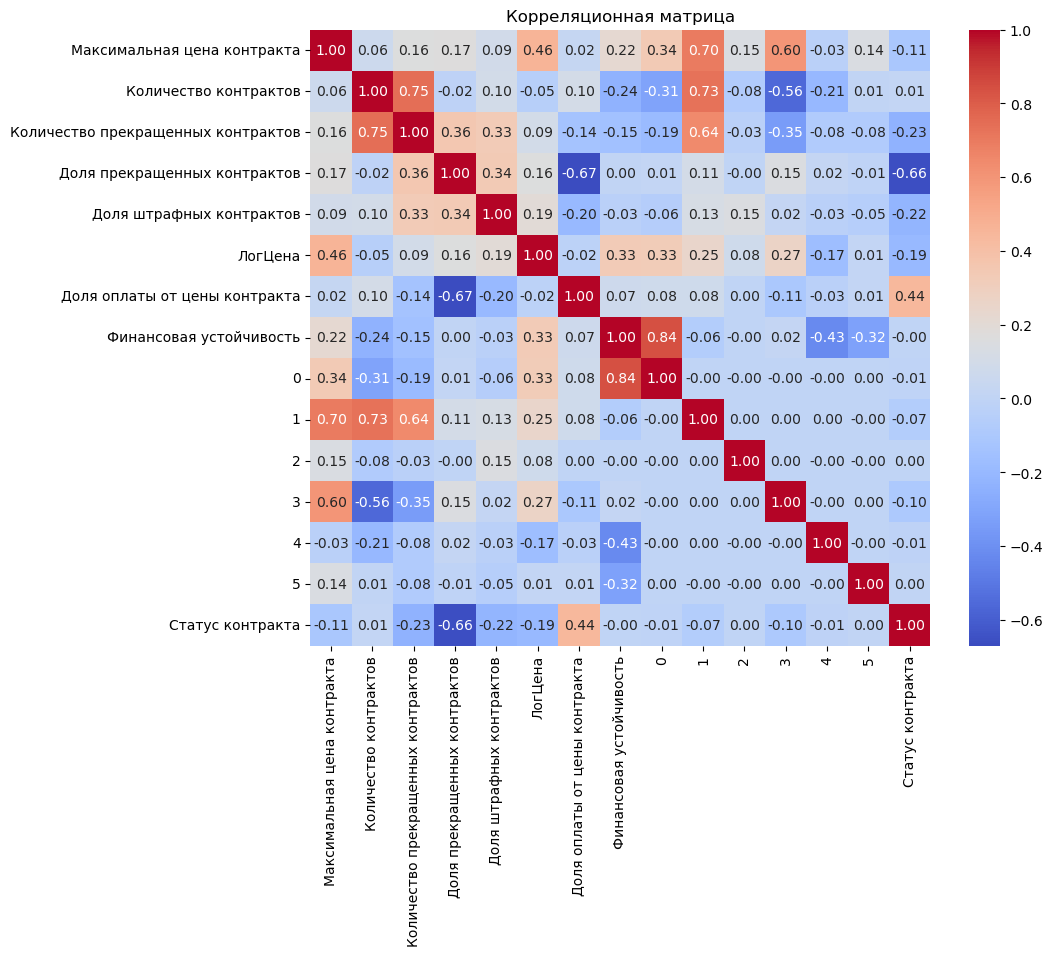

In [125]:
numeric_df_2 =  pd.concat([X_with_pca, y], axis = 1)

corr_matrix_2 = numeric_df_2.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_2, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица")
plt.show()

In [126]:
#Random forest

In [144]:
model = RandomForestClassifier(
    n_estimators=300,     
    max_depth=15,        
    min_samples_split=2,   
    min_samples_leaf=3,   
    class_weight="balanced", 
    random_state=42           
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_tr = model.predict(X_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob >= 0.6).astype(int) 

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nClassification report for train:\n", classification_report(y_train, y_pred_tr))
print("\nClassification report with thrashhold:\n", classification_report(y_test, y_pred_custom))

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nБудущая важность:\n", feature_importance)

Confusion matrix:
 [[ 49  16]
 [ 29 203]]

Classification report:
               precision    recall  f1-score   support

           0       0.63      0.75      0.69        65
           1       0.93      0.88      0.90       232

    accuracy                           0.85       297
   macro avg       0.78      0.81      0.79       297
weighted avg       0.86      0.85      0.85       297


Classification report for train:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       151
           1       0.98      0.94      0.96       540

    accuracy                           0.94       691
   macro avg       0.89      0.94      0.91       691
weighted avg       0.94      0.94      0.94       691


Classification report with thrashhold:
               precision    recall  f1-score   support

           0       0.60      0.83      0.70        65
           1       0.95      0.84      0.89       232

    accuracy                           

In [129]:
first_df.head()

,ИНН исполнителя,Сумма контрактов,Средняя цена контракта,Максимальная цена контракта,Сумма оплат,Средняя сумма оплат,Количество контрактов,Доходы,Расходы,Прибыль(убыток),Количество прекращенных контрактов,Неустойки (штрафы и пени),Включение в реестр недобросовестных поставщиков
0,1001232969,6411767.74,8.014710e+05,2078639.03,4979487.33,6.224359e+05,8,3903000.0,3797000.0,106000.0,2,0,0
1,1001334880,2904975.34,2.904975e+06,2904975.34,0.00,NaN,1,NaN,NaN,NaN,1,0,0
2,110110067712,6161831.51,3.080916e+06,4055831.51,6161831.51,3.080916e+06,2,NaN,NaN,NaN,0,0,0
3,1101159127,132459.55,1.324595e+05,132459.55,132459.55,1.324595e+05,1,15657000.0,390000.0,15267000.0,0,0,0
4,1435361389,790682.78,3.953414e+05,478406.28,223452.37,1.117262e+05,2,NaN,NaN,NaN,2,1,0


In [130]:
pd.set_option("display.float_format", "{:.2f}".format)
first_df[['Сумма контрактов','Средняя цена контракта', 'Количество контрактов']].describe().round(2)

,Сумма контрактов,Средняя цена контракта,Количество контрактов
count,286.00,286.00,286.00
mean,9835177.77,2957330.51,3.45
std,20242091.60,6148321.46,5.18
min,7806.00,7806.00,1.00
25%,627997.72,352509.51,1.00
50%,1814701.70,1098354.17,2.00
75%,8643764.62,2496720.46,4.00
max,136712958.98,67443982.62,46.00


In [131]:
group_status = not_changed_df.groupby("Статус контракта", as_index = False).agg({'ИНН исполнителя': 'nunique'})
group_status

,Статус контракта,ИНН исполнителя
0,Исполнение завершено,244
1,Исполнение прекращено,112
